In [65]:
using CSV
using Dates
using Distributions
using Glob
using Leaf
using PyPlot
using StatsBase
import ConjugatePriors: NormalInverseChisq

In [66]:
function publication_style(fontsize = 12)
    rc("axes", grid = true, titlesize = fontsize, xmargin = 0, ymargin = 0)
    rc("axes.grid", which = "both")
    rc("date.autoformatter", hour = "%d %b %I%p")
    rc("figure", figsize = (14, 2.0))
    rc("font", size = fontsize)
    rc("grid", alpha = 0.5, linestyle = "--")
    rc("legend", frameon = false)
    rc("lines", linewidth = 1.0)
end
publication_style(8)

In [100]:
function getstats(observations)
    observations = skipmissing(observations)

    obs_med = median(observations)
    obs_mad = mad(observations, normalize = true)
    # > If normalize is set to true, the MAD is multiplied by 1 / quantile(Normal(), 3/4) ≈ 1.4826,
    # > in order to obtain a consistent estimator of the standard deviation under the assumption that the data is normally distributed.
    obs_var = obs_mad^2

    obs_med, obs_var
end

function getprior(observations)
    obs_med, obs_var = getstats(observations)

    tp = TransitionDistributionPrior(
        Gamma(1, 1/0.01),
        Gamma(1, 1/0.01),
        Beta(500, 1)
    )

    op = DPMMObservationModelPrior{Normal}(
        NormalInverseChisq(obs_med, obs_var, 1, 10),
        Gamma(1, 0.5)
    )

    prior = BlockedSamplerPrior(1.0, tp, op)
end

function getsegments(seq)
    idxs = findall(seq[2:end] .!= seq[1:end-1])
    idxs = vcat([0], idxs, [length(seq)])
    collect(zip(idxs[1:end-1] .+ 1, idxs[2:end]))
end

# Returns the length of the contiguous segments in `seq`
function getdurations(seq)
    idxs = findall(seq[2:end] .!= seq[1:end-1])
    idxs = vcat([0], idxs, [length(seq)])
    idxs[2:end] .- idxs[1:end-1]
end

function plotrtt(ts, seq = nothing; ax = gca())
#     dates = unix2datetime.(ts.timestamp)
    dates = ts.timestamp
    ax.plot(dates, coalesce.(ts.min, NaN))
    if seq !== nothing
        cmap = Dict([i => plt.cm.tab20(i) for i in sort(unique(seq))])
        segments = getsegments(seq)
        for segment in segments
            state = seq[segment[1]]
            start, stop = dates[collect(segment)]
            ax.axvspan(start, stop, alpha = 0.3, color = cmap[state])
        end
    end
end

plotrtt (generic function with 2 methods)

In [105]:
files = glob("*.csv", joinpath(@__DIR__, "real_trace_labelled"))

config = MCConfig(init = KMeansInit(10), iter = 250, verb = false)
sampler = BlockedSampler(10, 5)

for file in files[20:end]
    @show file
    df = CSV.read(file, dateformat="dd/mm/yyyy HH:MM", delim=';', missingstrings=["-3", "-4"])

    df.min = df.rtt
    df.timestamp = collect(1:length(df.rtt))

    # TODO !
    rtt = coalesce.(df.rtt, mean(skipmissing(df.rtt)))
    
    prior = nothing
    try
        prior = getprior(rtt)
    catch
        prior = getprior(rtt)
    end
    
    chains = sample(sampler, prior, rtt, config = config)
    _, z, s, states = Leaf.select_hamming(chains[1])

    figure()
    plotrtt(df, z)
    for idx in findall(df.cp .== 1)
        plt.axvline(idx, color = "red")
    end
    plt.savefig("$file.png", bbox_inches = "tight", dpi = 300)
end

file = "/home/maxmouchet/Clones/Leaf.jl/examples/real_trace_labelled/11320.csv"
file = "/home/maxmouchet/Clones/Leaf.jl/examples/real_trace_labelled/11323.csv"
file = "/home/maxmouchet/Clones/Leaf.jl/examples/real_trace_labelled/11325.csv"
file = "/home/maxmouchet/Clones/Leaf.jl/examples/real_trace_labelled/11815.csv"
file = "/home/maxmouchet/Clones/Leaf.jl/examples/real_trace_labelled/11819.csv"
file = "/home/maxmouchet/Clones/Leaf.jl/examples/real_trace_labelled/11824.csv"
file = "/home/maxmouchet/Clones/Leaf.jl/examples/real_trace_labelled/11833.csv"
file = "/home/maxmouchet/Clones/Leaf.jl/examples/real_trace_labelled/12120.csv"
file = "/home/maxmouchet/Clones/Leaf.jl/examples/real_trace_labelled/12125.csv"
file = "/home/maxmouchet/Clones/Leaf.jl/examples/real_trace_labelled/12698.csv"
file = "/home/maxmouchet/Clones/Leaf.jl/examples/real_trace_labelled/12707.csv"


ErrorException: Failed to initialize transition matrix (NaN values), please check your priors.

In [57]:
file

"/home/maxmouchet/Clones/Leaf.jl/examples/real_trace_labelled/11185.csv"

In [8]:
_, z, s, states = Leaf.select_hamming(chains[1]);

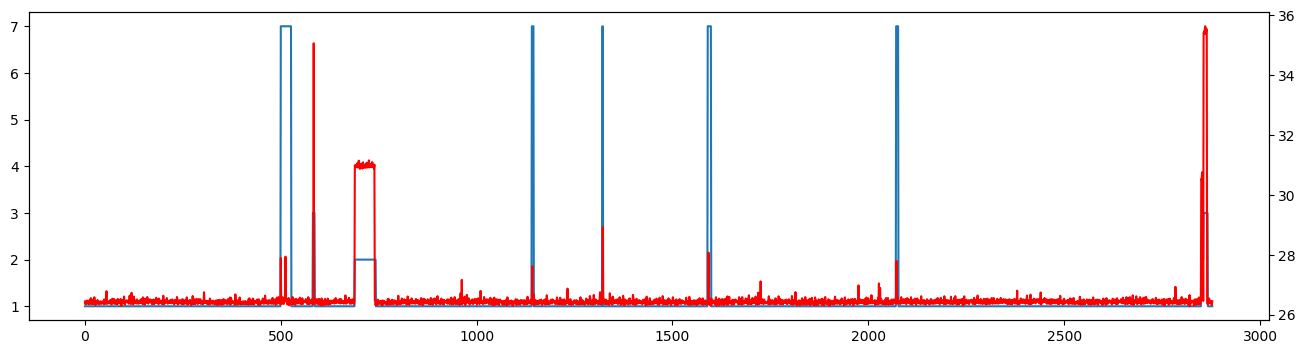

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2768825790>

In [9]:
figure(figsize=(16,4))
plot(z)
twinx().plot(y, color="red")

In [10]:
unique(z)

4-element Array{Int64,1}:
 1
 7
 3
 2

In [121]:
A = rand(100,10)

100×10 Array{Float64,2}:
 0.528069    0.0672795  0.815586   …  0.790619   0.143109   0.0614073
 0.353871    0.415335   0.496083      0.197914   0.304743   0.370279 
 0.316324    0.415719   0.41337       0.303298   0.912151   0.025333 
 0.791046    0.458829   0.327424      0.425227   0.129112   0.113641 
 0.305949    0.942165   0.274712      0.195901   0.441266   0.499544 
 0.680242    0.356047   0.504075   …  0.319698   0.999136   0.719858 
 0.00530497  0.447328   0.026714      0.493178   0.769462   0.533716 
 0.153614    0.353957   0.157108      0.6329     0.0284726  0.288399 
 0.583335    0.684251   0.220794      0.724997   0.75325    0.367349 
 0.447171    0.812222   0.206601      0.0482558  0.570264   0.398818 
 0.446368    0.276517   0.327359   …  0.82474    0.632551   0.972317 
 0.617448    0.608896   0.76616       0.15425    0.978892   0.486286 
 0.301358    0.636288   0.207844      0.47582    0.516606   0.939238 
 ⋮                                 ⋱                             

In [120]:
argmin(mean(A, dims=2))

CartesianIndex(30, 1)